# Predicting Startup Success

As investors we want to know which companies will succeed and which companies will fail so we can make smart investments.  Unfortunately there is no way to know ahead of time which companies will succeed or fail, however, we can try to predict success based on the huge amounts of data available online about startups.  For this project we will be analyzing data obtained through the [CrunchBase](https://www.crunchbase.com/) API.

The CrunchBase dataset, while extensive provides us with data that is pretty biased.  In order to be in the CrunchBase database, a company must already have become newsworthy.  Normally that means raising a significant round of funding or graduating from a prominent incubator.  We will take this bias into account when performing our analysis.  Simply raising one round of funding will not be considered a succesful outcome.

So how will we define success?  We will use a couple of indicators, and if a company achieves even a single one of these, we will consider the startup to be successful.  

So what are the indicators we are using? We will consider a company to be a success if it IPOs or if it is acquired (even though we are aware that many acquisitions may not be considered successes by employees or investors in a company, for this project we will be making this simplification and assuming all acquisitions are successes).  We will also consider a startup a success if it has raised several rounds of funding.  How many?  Well, since all the startups in the CrunchBase database have already raised one round, we will pretend we are making a second round investment.  Any companies that raise a thrid round will be considered succesful as they have proven that other investors are interested in investing in this company after us.  Later we will show another reason why we chose 3 as a cutoff in the number of rounds of investment to be considered successful.

Not all companies are equally successful.  And perhaps it is best to weight your investments based on how certain you are that a company will succeed and how succesful that company will be, in terms of what the rate of return for a particular company is.  However, since we don't have all of the financial information for funding rounds, and none of the financial information for rate of return for different investors in different rounds of different companies, we will simply focus in this project on the overall success or failure of a company and treat this as a classification problem, rather than a regression problem.

#Data Cleaning

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import json
import datetime
import time

In [178]:
# Focus on the start up founded before 2010
with open("tmp/organizations_dict_to2010.json", "r") as fd:
    orgs = json.load(fd)

In [3]:
orgs.values()[-10:]

[{u'acquired_by': [],
  u'acquisitions': [],
  u'board_members_and_advisors': [],
  u'categories': [{u'name': u'Real Estate'}],
  u'competitors': [],
  u'founders': [],
  u'funding_rounds': [{u'announced_on': u'2011-03-01',
    u'funding_type': u'venture',
    u'money_raised_usd': 50000000}],
  u'headquarters': [{u'city': u'Pudong', u'country': u'China'}],
  u'investors': [{u'permalink': u'baidu'}],
  u'ipo': [],
  u'offices': [{u'city': u'Pudong', u'country': u'China'}]},
 {u'acquired_by': [],
  u'acquisitions': [],
  u'board_members_and_advisors': [],
  u'categories': [{u'name': u'Software'},
   {u'name': u'Big Data'},
   {u'name': u'Predictive Analytics'},
   {u'name': u'Machine Learning'},
   {u'name': u'Data Visualization'},
   {u'name': u'Artificial Intelligence'}],
  u'competitors': [{u'permalink': u'clearstory-data'},
   {u'permalink': u'sisense'},
   {u'permalink': u'datameer'},
   {u'permalink': u'ibm'}],
  u'founders': [{u'bio': u"Martin\u2019s focus is operations and invest

In [4]:
df=pd.DataFrame(orgs.values(),index=orgs.keys())

Copied this from HW5, to get adjectives and nouns from the short_description

In [5]:
from sklearn.feature_extraction import text 
stopwords=text.ENGLISH_STOP_WORDS
import re
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')
# taken from HW5
def get_parts(thetext):
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    nouns=[]
    descriptives=[]
    for i,sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        nouns.append([])
        descriptives.append([])
        for token in sentence:
            if len(token[4]) >0:
                if token[1] in ['JJ', 'JJR', 'JJS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    descriptives[i].append(token[4])
                elif token[1] in ['NN', 'NNS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns[i].append(token[4])
    out=zip(nouns, descriptives)
    nouns2=[]
    descriptives2=[]
    for n,d in out:
        if len(n)!=0 and len(d)!=0:
            nouns2.append(n)
            descriptives2.append(d)
    return nouns2, descriptives2


In [6]:
# If no description we set the short description to 0 to apply the mapping
df['short_description'] = df.short_description.fillna(0)

In [7]:
# add column for description nouns and adjectives
df['text_nouns']=df.short_description.map(lambda x: [] if isinstance(x, int) else get_parts(x)[0]).map(lambda x: [item for sublist in x for item in sublist])
df['text_adjectives']=df.short_description.map(lambda x: [] if isinstance(x, int) else get_parts(x)[1]).map(lambda x: [item for sublist in x for item in sublist])

In [8]:
# add indicator columns for each category
catlist=df.categories.map(lambda x: None if x==None or isinstance(x,float) else [a['name'] for a in x]).tolist()
catset=set([item for sublist  in catlist if sublist!=None for item in sublist])
for category in catset:
    df["c_"+category+"_i"]=pd.Series(catlist, index=df.index).map(lambda x: category in x if x else False)

In [9]:
# add indicator columns for investors
investorslist=df.investors.map(lambda x: None if x==None or isinstance(x,float) else [a['permalink'] for a in x]).tolist()
investorset=set([item for sublist  in investorslist if sublist!=None for item in sublist])
for inv in investorset:
    df["i_"+inv+"_i"]=pd.Series(investorslist, index=df.index).map(lambda x: inv in x if x else False)

In [10]:
# add indicator columns for cities (from offices)
citylist=df.offices.map(lambda x: None if not x or isinstance(x,float) else [a['city'] for a in x]).tolist()
cityset=set([item for sublist  in citylist if sublist!=None for item in sublist])
for city in cityset:
    if city != None:
        df["city_"+city+"_i"]=pd.Series(citylist, index=df.index).map(lambda x: city in x if x else False)

In [11]:
# add indicator columns for headquarter country
countrylist=df.headquarters.map(lambda x: None if not x or isinstance(x,float) else [a['country'] for a in x]).tolist()
countryset=set([item for sublist  in countrylist if sublist!=None for item in sublist])
for country in countryset:
    if country != None:
        df["country_"+country+"_i"]=pd.Series(countrylist, index=df.index).map(lambda x: city in x if x else False)

After adding indicator columns, we now get some more data from the fields that currently exist as dictionaries/lists

In [12]:
df['funding_dates']=df.funding_rounds.map(lambda x:[] if not x or isinstance(x,float) else [datetime.datetime(*time.strptime(a['announced_on'], '%Y-%m-%d')[:3]) for a in x])

In [13]:
df['funding_amounts']=df.funding_rounds.map(lambda x:[] if not x or isinstance(x,float) else [float(a['money_raised_usd']) if a['money_raised_usd'] != None else 0 for a in x])

In [14]:
df['num_funding_rounds']=df.funding_amounts.map(lambda x: len(x))

In [15]:
df['funding_mean']=df.funding_amounts.map(lambda x: np.mean(x))
df['funding_total']=df.funding_amounts.map(lambda x: np.sum(x))

/Users/charlesliu/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [16]:
df['went_ipo']=df.ipo.map(lambda x: True if x else False)

In [17]:
df['was_acquired']=df.acquired_by.map(lambda x: True if x else False)

In [18]:
df['founder_names']=df.founders.map(lambda x:[] if not x or isinstance(x,float) else [a['permalink']  for a in x])
df['num_founders']=df.founders.map(lambda x: np.count_nonzero(x))

In [19]:
df['founder_ages'] = df.founders.map(lambda x:[] if not x or isinstance(x,float) else [(datetime.date.today()-datetime.date(*time.strptime(a['born_on'],'%Y-%m-%d')[:3])).days/365 for a in x if isinstance(a['born_on'],unicode)])
df['founder_ages_mean'] = df.founder_ages.map(lambda x: np.mean(x) if len(x) >0 else 0)
df['num_competitors'] = df.competitors.map(lambda x: np.count_nonzero(x))
df['num_acquisitions'] = df.acquisitions.map(lambda x: np.count_nonzero(x))
df['num_board_members_and_advisors'] = df.board_members_and_advisors.map(lambda x: np.count_nonzero(x))

In [20]:
df.head()

,acquired_by,acquisitions,board_members_and_advisors,categories,competitors,founders,funding_rounds,headquarters,investors,ipo,moonth_founded,offices,short_description,text_nouns,text_adjectives,c_Marketplaces_i,c_Veterinary_i,c_Crowdsourcing_i,c_Data Privacy_i,c_B2B_i,c_Online Video Advertising_i,c_Event Management_i,c_Corporate IT_i,c_Health and Insurance_i,c_Crowdfunding_i,c_Performance Marketing_i,c_Incentives_i,c_Social Television_i,c_Communications Infrastructure_i,c_Collaborative Consumption_i,c_Lighting_i,c_Virtual Currency_i,c_Designers_i,c_Tourism_i,c_Concentrated Solar Power_i,c_Training_i,c_Indians_i,c_Knowledge Management_i,c_Celebrity_i,c_Automated Kiosk_i,c_Call Center Automation_i,c_Social Media Marketing_i,c_Sensors_i,c_Restaurants_i,c_Cosmetic Surgery_i,c_Portals_i,c_Clinical Trials_i,c_Independent Music Labels_i,c_Customer Support Tools_i,c_Testing_i,...,country_Finland_i,country_Mexico_i,country_Moldova_i,country_United States_i,country_Belgium_i,country_Sweden_i,country_Latvia_i,country_Luxembourg_i,country_Monaco_i,country_Switzerland_i,country_Belarus_i,country_New Zealand_i,country_Nepal_i,country_Taiwan_i,country_Brazil_i,country_Bulgaria_i,country_Pakistan_i,country_Romania_i,country_Philippines_i,country_Portugal_i,country_Estonia_i,country_South Africa_i,country_Egypt_i,country_United Arab Emirates_i,country_Uruguay_i,country_India_i,country_Peru_i,country_United Kingdom_i,country_Malaysia_i,country_Austria_i,country_Vietnam_i,country_Tunisia_i,country_Colombia_i,country_Greece_i,country_Japan_i,country_South Korea_i,funding_dates,funding_amounts,num_funding_rounds,funding_mean,funding_total,went_ipo,was_acquired,founder_names,num_founders,founder_ages,founder_ages_mean,num_competitors,num_acquisitions,num_board_members_and_advisors
objectway,[],[],[],[{u'name': u'Software'}],[],[],"[{u'announced_on': u'2012-12-05', u'funding_ty...","[{u'city': u'Milan', u'country': u'Italy'}]",[],[],NaN,"[{u'city': u'Milan', u'country': u'Italy'}]",0,[],[],False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,[2012-12-05 00:00:00],[13065000.0],1,13065000.0,13065000,False,False,[],0,[],0,0,0,0
express-inn-hotel,[],[],[],[{u'name': u'Real Estate'}],[],[],"[{u'announced_on': u'2014-11-19', u'funding_ty...","[{u'city': u'Junction City', u'country': u'Uni...",[],[],2008-08,"[{u'city': u'Junction City', u'country': u'Uni...","Hotel opportunity: Selling 50% equity for $1M,...","[opportunity, equity, partner, salary, profit,...",[50%],False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,[2014-11-19 00:00:00],[50000.0],1,50000.0,50000,False,False,[],0,[],0,0,0,0
rebounces,[],[],[],[{u'name': u'Sports'}],[],[],"[{u'announced_on': u'2010-05-20', u'funding_ty...","[{u'city': u'Harrison', u'country': u'United S...",[],[],2008-09,"[{u'city': u'Harrison', u'country': u'United S...","reBounces has developed, patented and sold the...","[rebounce, cost, solution, tennis, ball]","[patented, effective, bulk]",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6852 entries, objectway to lodo-software
Columns: 9033 entries, acquired_by to num_board_members_and_advisors
dtypes: bool(9006), float64(3), int64(5), object(19)
memory usage: 60.3+ MB


Ways to improve our cleaning:
* Imputation of the missing value based on the neighborhood: right now we set the missing value to None (and so False in the indicator) maybe we could impute them based on the average value among all the data or among the closest entries.
* We are not considering the short-description. We could try to extract from them the meaningful words (same for the bio, for instance the background of the person)

# EDA

To begin our exploratory data analysis, let's first take a look at how many companies match each of our different success metrics.

In [22]:
# The number of rows of companies in our sample that were acquired
print "Number of companies that were acquired: %s" % len(df[df.was_acquired == True])
print "Number of companies with at least 1 funding round: %s" % len(df[df.num_funding_rounds > 0])
print "Number of companies that IPOed: %s" % len(df[df.went_ipo == True])

Number of companies that were acquired: 1072
Number of companies with at least 1 funding round: 6626
Number of companies that IPOed: 502


Clearly Acquired and IPOed are good indicators, but funding rounds appears to be a prerequisite to making it into the CrunchBase system.  Perhaps we can be more discerning in determining which companies that raised funds are considered succesful, maybe a specific amount or number of rounds.  

Let's take a closer look at funding rounds, specifically total amount raised:

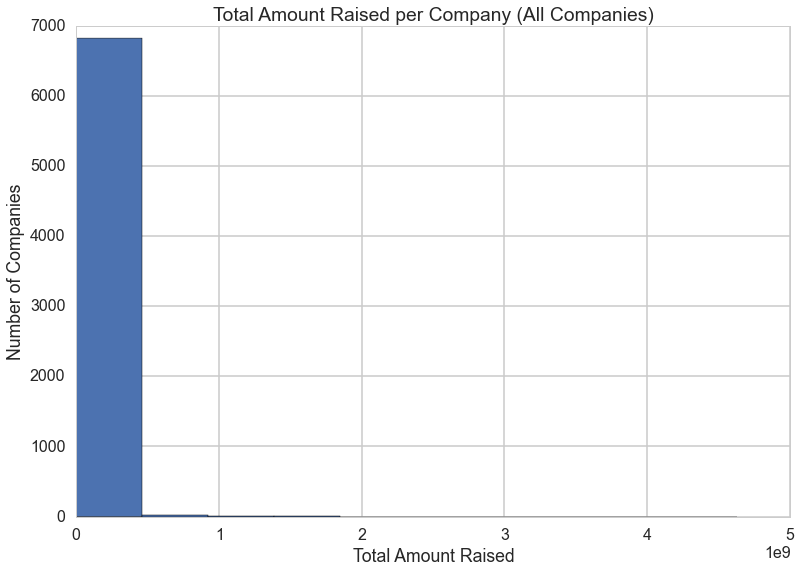

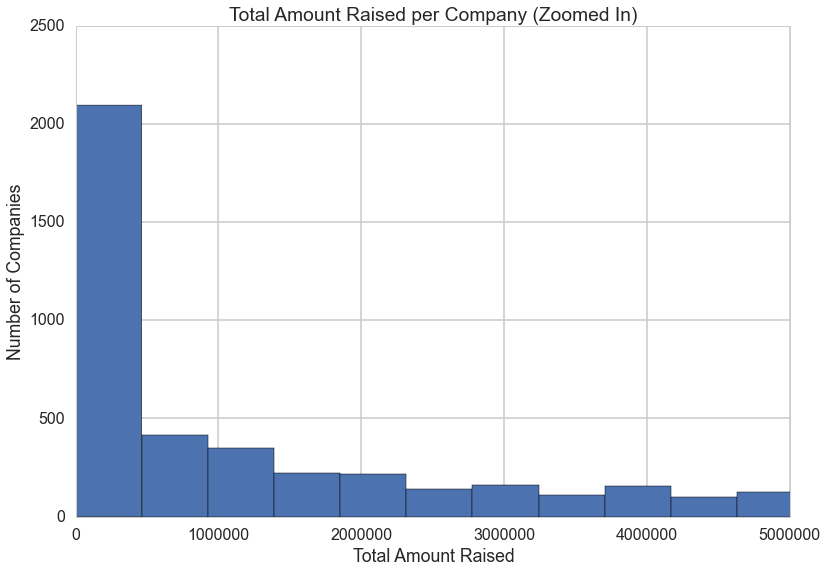

In [26]:
plt.hist(df.funding_total)
plt.title('Total Amount Raised per Company (All Companies)')
plt.xlabel('Total Amount Raised')
plt.ylabel('Number of Companies')
plt.show()

plt.xlim(0,5000000)
plt.hist(df.funding_total, bins=10000)
plt.title('Total Amount Raised per Company (Zoomed In)')
plt.xlabel('Total Amount Raised')
plt.ylabel('Number of Companies')
plt.show()

The majority of companies raised less than $2,000,000.  The amount of companies that raised a given amount very quickly drops off and goes into a long, sparse tail.  However, since this data is normally private, lots of rounds are missing their amounts.  We need to keep that in mind as we progress with our analysis.  

Let's take a look at the number of rounds each company raised:

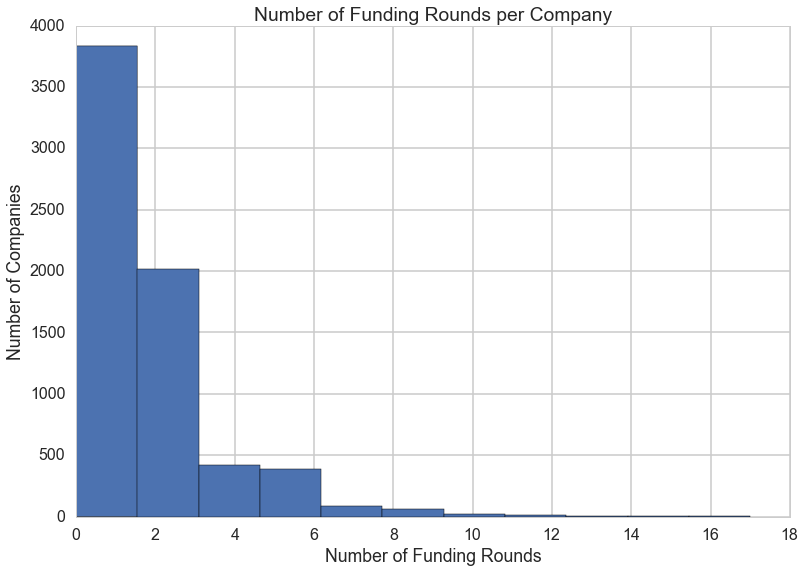

In [27]:
plt.hist(df.num_funding_rounds, bins=11)
plt.title('Number of Funding Rounds per Company')
plt.xlabel('Number of Funding Rounds')
plt.ylabel('Number of Companies')
plt.show()

Again, we see that most companies are clustered near the bottom of our range with 0-3 rounds raised.  4 or more rounds raised is not very common.  Perhaps we can use that as an indicator of success, seeing as how it appears to be less sparse than the total amount raised column.  Perhaps this is due to the prevalence of companies and investors announcing that they raised a round, but not disclosing the exact amounts of that round.

Let's see how many companies had at least 4 rounds:

In [28]:
print "Number of companies that raised at least 4 rounds: %s" % len(df[df.funding_amounts.map(lambda x: len(x) >= 4)])

Number of companies that raised at least 4 rounds: 1001


That looks like a good number.  Let's add that as an indicator column to the dataframe, and see how many companies fall into one of our three indicator columns (Acquired, IPOed, > 3 Rounds Raised) now:

In [29]:
df['at_least_4_funding_rounds']=df.funding_amounts.map(lambda x: len(x) >= 4)

In [32]:
# Let's count how many companies match at least one of our success criteria:
success_companies = len(df[(df['at_least_4_funding_rounds'] == True) | (df['was_acquired'] == True) | (df['went_ipo'] == True)])
print "Number of companies we consider to be a success: %s" % success_companies

df['success'] = ((df['at_least_4_funding_rounds'] == True) | (df['was_acquired'] == True) | (df['went_ipo'] == True))
df['success'] = df.success.map(lambda x: 1 if x else 0)
print "Success rate = {}".format(success_companies*1./len(df))

Number of companies we consider to be a success: 2153
Success rate = 0.314214827788


This may seem like a high success rate when compared to [other metrics about start-up success](http://www.forbes.com/sites/neilpatel/2015/01/16/90-of-startups-will-fail-heres-what-you-need-to-know-about-the-10/), but remember that the companies that make it into CrunchBase are already quite a selective bunch.  As we saw above, most companies in CrunchBase have already raised at least 1 round, so this does not seem like such a high success rate considering this is already a pretty select crowd of companies.

### Split the data

We'll finish the data cleaning and list the features we don't really need (if we retrieve more data from the API, it will save us time).

Let's split our dataset into training, validation and testing sets.  We need to clean up the columns first and separate the success column from the rest of the data.  We'll also remove any columns that the success column is dependent on (went_ipo, was_acquired, etc....). 

Then we'll split out the testing data from the training data.  
// NOT SURE IF WE DO THIS // We'll then perform a second split on the training data to get the validation data.

In [33]:
# Usable for the Data scrapping part
features_with_only_nan = ['investments', 'owned_by']

In [34]:
cleandf = df.copy()

# Drop unnecessary columns
X = cleandf.drop(['success', 'competitors', 'at_least_4_funding_rounds', 'was_acquired', 'went_ipo', 'funding_total', 'funding_mean', 'acquired_by', 'funding_rounds', 'investors', 'ipo', 'funding_dates', 'num_funding_rounds', 'funding_amounts', 'categories', 'text_nouns', 'text_adjectives', 'short_description', 'founder_ages'], axis=1)
# These columns can probably be converted to numerical form with 
# some positive impact on the models, so don't rule them out 
# completely just yet, but be careful that they are not dependent
# with any of our success indicators
X = X.drop(['acquisitions', 'board_members_and_advisors', 'founders', 'offices', 'headquarters', 'founder_names', 'moonth_founded'], axis=1)
print X.shape

# The success column
y = df['success']
print y.shape
X.head()

(6852, 9009)
(6852,)


,c_Marketplaces_i,c_Veterinary_i,c_Crowdsourcing_i,c_Data Privacy_i,c_B2B_i,c_Online Video Advertising_i,c_Event Management_i,c_Corporate IT_i,c_Health and Insurance_i,c_Crowdfunding_i,c_Performance Marketing_i,c_Incentives_i,c_Social Television_i,c_Communications Infrastructure_i,c_Collaborative Consumption_i,c_Lighting_i,c_Virtual Currency_i,c_Designers_i,c_Tourism_i,c_Concentrated Solar Power_i,c_Training_i,c_Indians_i,c_Knowledge Management_i,c_Celebrity_i,c_Automated Kiosk_i,c_Call Center Automation_i,c_Social Media Marketing_i,c_Sensors_i,c_Restaurants_i,c_Cosmetic Surgery_i,c_Portals_i,c_Clinical Trials_i,c_Independent Music Labels_i,c_Customer Support Tools_i,c_Testing_i,c_Water Purification_i,c_Defense_i,c_Flash Storage_i,c_SNS_i,c_Non Profit_i,c_Telecommunications_i,c_Building Products_i,c_Ticketing_i,c_Freelancers_i,c_Video Streaming_i,c_RFID_i,c_Lead Management_i,c_Sponsorship_i,c_Mobile Payments_i,c_High Schools_i,...,country_Serbia_i,country_Spain_i,country_Ukraine_i,country_Mauritius_i,country_The Netherlands_i,country_Indonesia_i,country_Uganda_i,country_Denmark_i,country_Poland_i,country_Finland_i,country_Mexico_i,country_Moldova_i,country_United States_i,country_Belgium_i,country_Sweden_i,country_Latvia_i,country_Luxembourg_i,country_Monaco_i,country_Switzerland_i,country_Belarus_i,country_New Zealand_i,country_Nepal_i,country_Taiwan_i,country_Brazil_i,country_Bulgaria_i,country_Pakistan_i,country_Romania_i,country_Philippines_i,country_Portugal_i,country_Estonia_i,country_South Africa_i,country_Egypt_i,country_United Arab Emirates_i,country_Uruguay_i,country_India_i,country_Peru_i,country_United Kingdom_i,country_Malaysia_i,country_Austria_i,country_Vietnam_i,country_Tunisia_i,country_Colombia_i,country_Greece_i,country_Japan_i,country_South Korea_i,num_founders,founder_ages_mean,num_competitors,num_acquisitions,num_board_members_and_advisors
objectway,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0
express-inn-hotel,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0
rebounces,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0
ivycorp,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,Fals

In [35]:
from sklearn.cross_validation import train_test_split
# Make the train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Split the training data into train/validate set
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.20, random_state=42)


# Training
print X_train.shape
print y_train.shape

# Validate
print X_validate.shape
print y_validate.shape

# Testing
print X_test.shape
print y_test.shape

(4932, 9009)
(4932,)
(1234, 9009)
(1234,)
(686, 9009)
(686,)


We will save these files now to ensure that we can come back to this point if needed.

In [36]:
X_train.to_csv("tmp/X_train.csv", index=True, header=True, encoding="utf-8")
y_train.to_csv("tmp/y_train.csv", index=True, header=True, encoding="utf-8")

X_validate.to_csv("tmp/X_validate.csv", index=True, header=True, encoding="utf-8")
y_validate.to_csv("tmp/y_validate.csv", index=True, header=True, encoding="utf-8")

X_test.to_csv("tmp/X_test.csv", index=True, header=True, encoding="utf-8")
y_test.to_csv("tmp/y_test.csv", index=True, header=True, encoding="utf-8")

# Bring out the Models

## The Baseline Model

Now we will attempt to find a baseline to improve upon. A basic baseline would be assuming that all companies fail or all companies succeed.  Let's take a look at what those two assumptions would yield.

In [37]:
# Loading the data with the index
X_train = pd.read_csv("tmp/X_train.csv", index_col='Unnamed: 0')
y_train = pd.read_csv("tmp/y_train.csv", index_col='Unnamed: 0').success

X_validate = pd.read_csv("tmp/X_validate.csv", index_col='Unnamed: 0')
y_validate = pd.read_csv("tmp/y_validate.csv", index_col='Unnamed: 0').success

X_test = pd.read_csv("tmp/X_test.csv", index_col='Unnamed: 0')
y_test = pd.read_csv("tmp/y_test.csv", index_col='Unnamed: 0').success

In [54]:
# Assume all companies fail
print "Accuracy of the model assuming all succeed: %s" % (len(y_test[y_test == True]) / (1.0 * len(y_test)))

# Assume all companies succeed
print "Accuracy of the model assuming all fail: %s" % (len(y_test[y_test == False]) / (1.0 * len(y_test)))

Accuracy of the model assuming all succeed: 0.33527696793
Accuracy of the model assuming all fail: 0.66472303207


So the basic baseline to beat is 66.5%, which we get if we just assume all companies will fail.  That's not so hot. Throughout the rest of this notebook we will be trying to create a predictive model to beat it

Also recall: we are looking to invest in companies that we think will be successful. Although we are trying to predict the success of a company, it's a little more nuanced - we are moreso trying to find the next successful company. Remember that our models will consider a success companies with >50% probability threshold of being successful. We should also look at adjusted thresholds according to what is more costly to us - false positives or false negatives?

A false positive would potentially lead to us funding a startup that will eventually fail.
A false negative would potentially lead to us missing out on a startup that's successful.

To see what is more costly, we must look at our baselines from the perspective of utility - we need to come up with some profit assumption based on some cost. This is hard to do as the majority of our "success" companies will either have been acquired or have gotten more than 4 rounds of funding - the true valuation and therefore return on an investment in this company isn't a known quantity.

In terms of cost - let's assume we are a Y-combinator like fund but a lot less known. Terms with Ycomb are typically around 100K for 6% of the company. With us, let's say we offer 50K for 2.5%.

Given we don't know much about the cash flows of our success companies to come up with a valuation, let's just assume it is worth as much as the sum of it's funding rounds - hence our value in the company is 2.5% of the sum of the funding rounds. These values for our companies are incredibly skewed also, so instead of taking an average let's use the median value.

In [48]:
#true negative cost is 0 - 0 invested, 0 missed out on
tnc = 0
#true positive cost is seed investment - median valuation * seed equity we would have had
median_valuation = np.median(df[df['success']==1].funding_total)
seed_investment = 50000
seed_equity = .025
tpc = seed_investment - median_valuation*seed_equity
tpc

-250000.0

In [49]:
#false negative cost is a startup we missed out on
fnc = median_valuation*seed_equity
#false positive is 
fnc

300000.0

In [50]:
#false positive cost is oru initial seed investment that's gone
fpc = seed_investment
fpc

50000

Can someone say bubble? The cost of a false negative is 6x more than a false positive. That means in our analysis, we should be less strict on the probability threshold of a success. Indeed, this seems to be a strategy it seems all the incubators and VC firms are employing - invest a bit of money in a lot of startups in the hopes that one makes it big

In [51]:
risk_matrix=np.array([[tnc, fpc],[fnc, tpc]])
u = -risk_matrix
u

array([[     -0.,  -50000.],
       [-300000.,  250000.]])

In [53]:
#Some functions from HW3 that will be reused
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

def average_profit_pp(y, ypred, u):
    c=confusion_matrix(y,ypred)
    score=np.sum(c*u)/np.sum(c)
    return score

def t_repredict(est, t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

def percentage(tpr, fpr, priorp, priorn):
    perc = tpr*priorp + fpr*priorn
    return perc

def av_profit(tpr, fpr, util, priorp, priorn):
    profit = priorp*(util[1][1]*tpr+util[1][0]*(1.-tpr))+priorn*(util[0][0]*(1.-fpr) +util[0][1]*fpr)
    return profit

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

def make_profit(name, clf, ytest, xtest, util, ax=None, threshold=False, labe=200, proba=True):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    priorp=np.mean(ytest)
    priorn=1. - priorp
    ben=[]
    percs=[]
    for i,t in enumerate(thresholds):
        perc=percentage(tpr[i], fpr[i], priorp, priorn)
        ev = av_profit(tpr[i], fpr[i], util, priorp, priorn)
        ben.append(ev)
        percs.append(perc*100)
    ax.plot(percs, ben, '-', alpha=0.3, markersize=5, label='utlity curve for %s' % name)
    if threshold:
        label_kwargs = {}
        label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
        )
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (percs[k], ben[k]), **label_kwargs)
    ax.legend(loc="lower right")
    return ax

Let's now calculate our baselines according to the utility matrix

In [114]:
#Don't seed anyone
all_zeros = np.zeros(len(y_test), dtype="int")
zeros_baseline_profit = average_profit_pp(y_test, all_zeros, u)
zeros_baseline_profit

-100583.09037900875

In [115]:
#Seed everyone
all_ones = np.ones(len(y_test), dtype="int")
ones_baseline_profit = average_profit_pp(y_test, all_ones, u)
ones_baseline_profit

50583.090379008747

When looking at it from a profit perspective, as expected given our utility matrix we are trying to beat the seed all startups baseline. We'd definitely want to beat this and be more selective because we don't have that kind of money!

We will now start looking at predictive models in an attemp to beat the baseline. We will first focus on beating the all-fails 66% baseline; at the end we will compile all our models and try to form an ensemble. Finally, we will look at it from the ROC/profit curve perspective and see if we can beat the all-success profit baseline.

## K-Nearest Neighbors

Here we will perform a K-Nearest Neighbors classification to predict if a company will be successful or not based upon the training data.  The two categories into which we will be classifying our data are succesful or not succesful.

Here we will use the [scikit-learn](http://scikit-learn.org/stable/modules/neighbors.html) KNeighborsClassifier to perform our classification.  We will start with the with weights set to 'uniform', which is the default and then try some other weighting formulas.

In [58]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
validate_accuracy = knc.score(X_validate,y_validate)
print "Validate accuracy with weights = 'uniform' and n_neighbors = 5: %s " % validate_accuracy

Validate accuracy with weights = 'uniform' and n_neighbors = 5: 0.722042139384 


We're already seeing a pretty solid improvement over the baseline seed-none 

Perhaps if we increase the number of neigbors to query it'll be even better:

In [59]:
knc = KNeighborsClassifier(n_neighbors=20)
knc.fit(X_train, y_train)
validate_accuracy = knc.score(X_validate,y_validate)
print "Validate accuracy with weights = 'uniform' and n_neighbors = 20: %s" % validate_accuracy

Validate accuracy with weights = 'uniform' and n_neighbors = 20: 0.721231766613


Didn't see too much difference.  Let's graph the n_neighbors by accuracy, but with a balanced training set:

In [74]:
#creating a balanced training set
index_train = np.arange(0, y_train.shape[0])
n_pos = len(np.where(index_train[y_train==1]>0)[0])
n_neg = len(np.where(index_train[y_train==0]>0)[0])
print n_pos, n_neg

1527 3405


/Users/charlesliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  app.launch_new_instance()
/Users/charlesliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [75]:
ineg = np.random.choice(np.where(index_train[y_train==0] > 0)[0], n_pos, replace=False)

/Users/charlesliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  if __name__ == '__main__':


In [77]:
alli = np.concatenate((np.where(index_train[y_train==1]>0)[0], ineg))
alli.shape

/Users/charlesliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  if __name__ == '__main__':


(3054,)

Saving the balanced training sets. If you want to load my balanced training set, don't run this. Run the cell below

In [120]:
X_train_bal = X_train.iloc[alli]
y_train_bal = y_train.iloc[alli]
X_train_bal.shape, y_train_bal.shape
X_train_bal.to_csv("tmp/X_train_bal.csv", index=True, header=True, encoding="utf-8")
y_train_bal.to_csv("tmp/y_train_bal.csv", index=True, header=True, encoding="utf-8")

In [ ]:
X_train_bal = pd.read_csv("tmp/X_train_bal.csv", index_col='Unnamed: 0')
y_train_bal = pd.read_csv("tmp/y_train_bal.csv", index_col='Unnamed: 0')

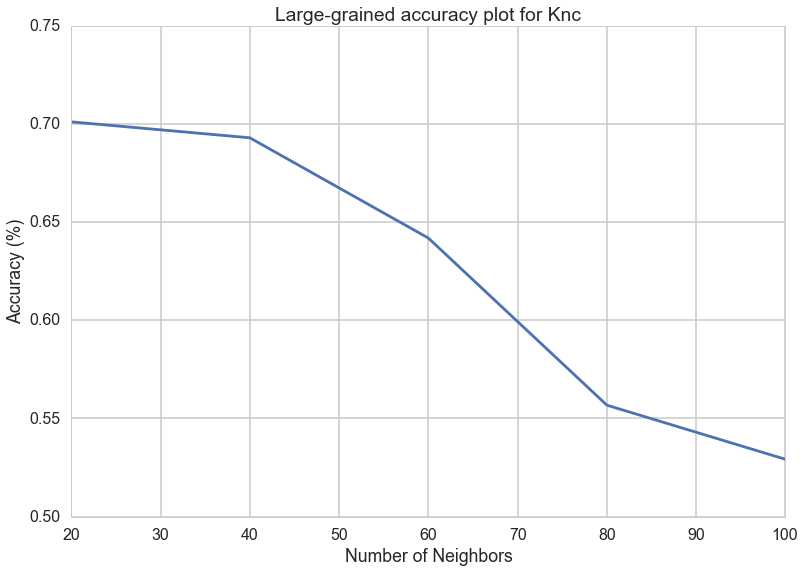

In [96]:
# GRAPH THE N_NEIGBORS (X-AXIS)  BY ACCURACY (Y-AXIS)!
# Large-grained
neighbors=[20,40,60,80,100]
accuracies=[]
max_neighbors = 0
max_accuracy = -float("inf")
for n in neighbors:
    knc = KNeighborsClassifier(n_neighbors=n)
    knc.fit(X_train_bal, y_train_bal)
    accuracies.append(knc.score(X_validate,y_validate))
    if accuracies[-1] > max_accuracy:
        max_accuracy = accuracies[-1]
        max_neighbors = n
plt.figure()
plt.plot(neighbors,accuracies)
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy (%)")
plt.title('Large-grained accuracy plot for Knc')
plt.show()

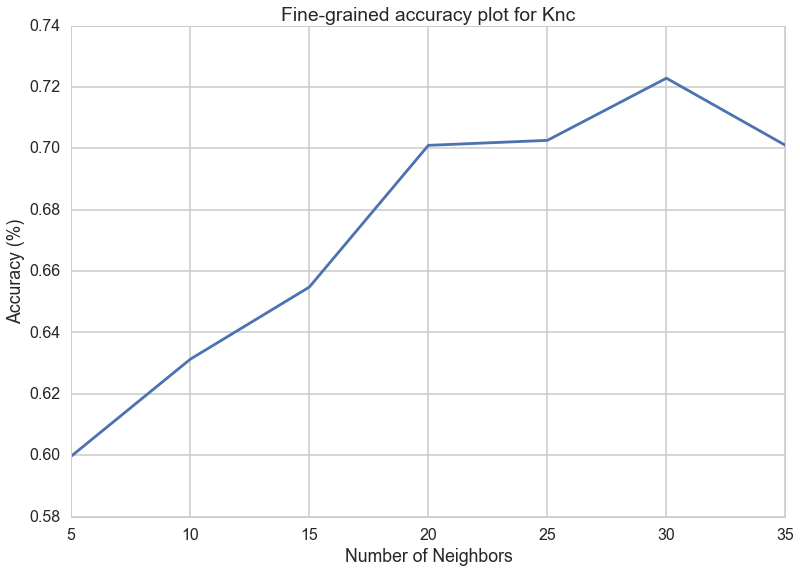

In [123]:
#More fine-grained
neighbors=[5,10,15,20,25,30,35]
accuracies=[]
max_neighbors = 0
max_accuracy = -float("inf")
for n in neighbors:
    knc = KNeighborsClassifier(n_neighbors=n)
    knc.fit(X_train_bal, y_train_bal)
    accuracies.append(knc.score(X_validate,y_validate))
    if accuracies[-1] > max_accuracy:
        max_accuracy = accuracies[-1]
        max_neighbors = n
plt.figure()
plt.plot(neighbors,accuracies)
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy (%)")
plt.title('Fine-grained accuracy plot for Knc')
plt.show()

In [124]:
print "Best neighbors was {} with max accuracy of {}".format(max_neighbors, max_accuracy)

Best neighbors was 30 with max accuracy of 0.722852512156


Now we'll try the KNeighborsClassifier with weights='distance':

In [125]:
knc = KNeighborsClassifier(n_neighbors=max_neighbors, weights='distance')
knc.fit(X_train_bal, y_train_bal)
validate_accuracy = knc.score(X_validate,y_validate)
print "Validate accuracy with weights='distance' and n_neighbors = {}: {}".format(max_neighbors, validate_accuracy)

Validate accuracy with weights='distance' and n_neighbors = 30: 0.712317666126


We don't see much improvement with the balanced training set over the knc defaults. Let's see how it fares on the test set

In [126]:
# Let's see how our test data fares using this KNC
test_accuracy = knc.score(X_test,y_test)
print "Test accuracy with weights='distance' and n_neighbors = {}: {}".format(max_neighbors, test_accuracy)

Test accuracy with weights='distance' and n_neighbors = 30: 0.718658892128


We didn't see as much improvement over the baseline as we had hoped, and with the profit curve never really beating the baseline profit curve it's clear we have a lot of work to do. Let's do a quick check on the original training data to see if using that would have produced better results

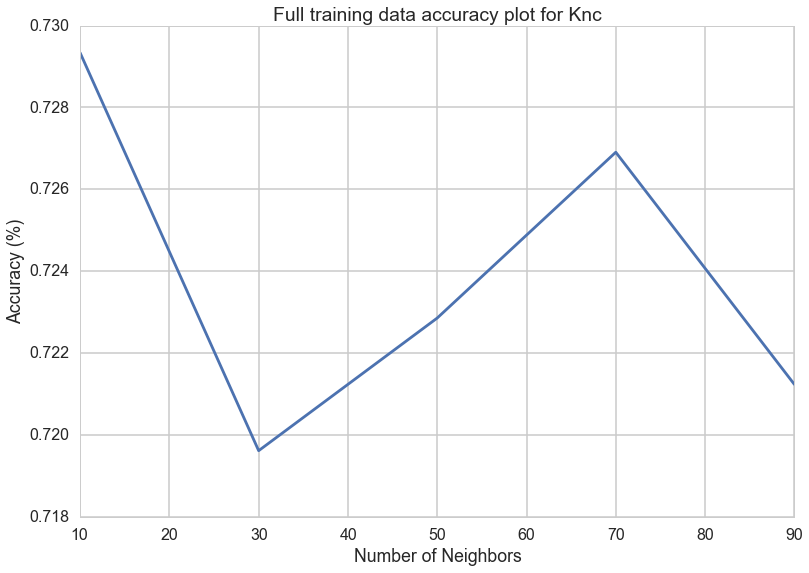

In [117]:
neighbors=[10, 30, 50, 70, 90]
accuracies=[]
max_neighbors_full = 0
max_accuracy_full = -float("inf")
for n in neighbors:
    knc = KNeighborsClassifier(n_neighbors=n)
    knc.fit(X_train, y_train)
    accuracies.append(knc.score(X_validate,y_validate))
    if accuracies[-1] > max_accuracy_full:
        max_accuracy_full = accuracies[-1]
        max_neighbors_full = n
plt.figure()
plt.plot(neighbors,accuracies)
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy (%)")
plt.title('Full training data accuracy plot for Knc')
plt.show()

The full training data gives a better prediction on the validation set - however it's quite choppy. It doesn't seem like this is a very reliable model, whereas with the balanced data set it was a relatively smooth peak to a maximum. Let's stick with that and move to more models, hopefully by the end we can have an ensemble of models that can perform better together

## Logistic Regression

Now let's try to fit this to a logistic regression. 

In [128]:
from sklearn.linear_model import LogisticRegressionCV

# Logistic regression with cross validation on 10-folds
log_reg = LogisticRegressionCV(cv=5, dual=False, penalty='l2', max_iter=100)
%time log_reg = log_reg.fit(X_train_bal, y_train_bal)

CPU times: user 5min 16s, sys: 2.45 s, total: 5min 19s
Wall time: 1min 29s


In [129]:
test_accuracy = log_reg.score(X_test, y_test)
print "Test accuracy with 5-fold cross val and l2 regularization: %s" % test_accuracy

Test accuracy with 5-fold cross val and l2 regularization: 0.728862973761


Logistic regression with l2 regularization was slightly better than the knn. Just to summarize up to this point: our baseline for prediction was assuming all startups failed. This led to a correct prediction rate of 66%. We've now raised that to by 6 percentage points!

## SVM

Given we're trying to predict success/failure, let's see if we can try a few SVM models to form a classifier for startups

In [130]:
from sklearn import svm

# We can try first a linear SVM
clf = svm.SVC(kernel='linear')
%time clf = clf.fit(X_train_bal, y_train_bal)

CPU times: user 2min 10s, sys: 338 ms, total: 2min 10s
Wall time: 2min 10s


In [131]:
test_accuracy = clf.score(X_test, y_test)
print "Test accuracy with kernel='linear': %s" % test_accuracy

Test accuracy with kernel='linear': 0.692419825073


In [132]:
# Now let's do rbf
clf = svm.SVC(kernel='rbf')
%time clf = clf.fit(X_train_bal, y_train_bal)

CPU times: user 1min 21s, sys: 301 ms, total: 1min 21s
Wall time: 1min 21s


In [133]:
test_accuracy = clf.score(X_test, y_test)
print "Test accuracy with kernel='rbf': %s" % test_accuracy

Test accuracy with kernel='rbf': 0.711370262391


In [134]:
# Now poly
clf = svm.SVC(kernel='poly')
%time clf = clf.fit(X_train_bal, y_train_bal)

CPU times: user 1min 23s, sys: 340 ms, total: 1min 24s
Wall time: 1min 24s


In [135]:
test_accuracy = clf.score(X_test, y_test)
print "Test accuracy with kernel='rbf': %s" % test_accuracy

Test accuracy with kernel='rbf': 0.66472303207


It seems the rbf kernel was the best, let's save this one

In [141]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train_bal, y_train_bal)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

## Naive Bayes on the short description

Now let's look at whether we can predict success from the presence of certain words in the short description. First, we write a function to find the top num_words in a description, then drop drop_words from the top (we don't clean the description for any common use words). We then return the score of the naive bayes classifier on the validation set

In [179]:
from sklearn.naive_bayes import BernoulliNB
def score_nb(num_words, drop_words):
    top_words=Counter(all_words).most_common(num_words+drop_words)
    top_words = top_words[drop_words:len(top_words)]
    #create a new dataframe with a column for each of these words, and whether a company's short description contains these words.
    words_df=pd.DataFrame(index=df.index)
    for word,count in top_words:
        # add column if word appears in adjectives or nouns
        words_df['word_'+word]=df.text_adjectives.map(lambda x: word in x)|df.text_nouns.map(lambda x: word in x)
    X_train_w=words_df.ix[X_train_bal.index]
    X_test_w=words_df.ix[X_test.index]
    X_validate_w=words_df.ix[X_validate.index]
    #We choose to run Bernoulli Naive Baye's as the classifier, since it does best with text classification given binary features for common words. There aren't any hyperparameters to fit.
    X_train_w = X_train_w.fillna(False)
    X_test_w = X_test_w.fillna(False)
    X_validate_w = X_validate_w.fillna(False)
    nb=BernoulliNB()
    nb.fit(X_train_w,y_train_bal)
    return nb.score(X_validate_w,y_validate)

In [180]:
# Import Counter, a library helpful for getting most common values out of a list
from collections import Counter
# get a list of all the adjectives and nouns, and then join them
adjectives=[item for sublist in df.text_adjectives.tolist() for item in sublist] 
nouns=[item for sublist in df.text_nouns.tolist() for item in sublist] 
all_words=adjectives+nouns

Let's make a plot to see what's a good number of words to use

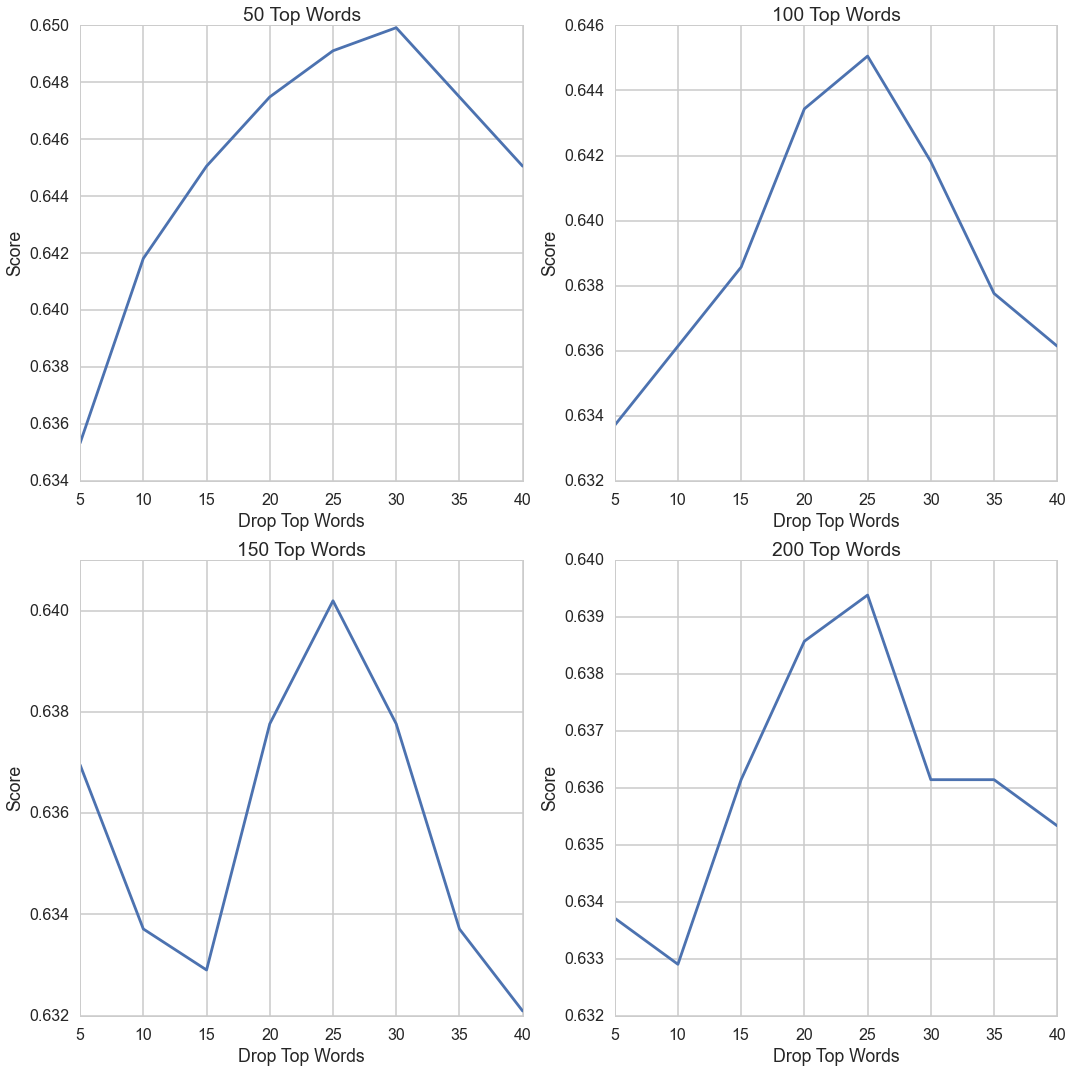

In [181]:
num_words = [50, 100, 150, 200]
drop_words = [5, 10, 15, 20, 25, 30, 35, 40]
fig, axes = plt.subplots(nrows = 2, ncols=2, figsize=(15,15), tight_layout=True)
for ax, num in zip(axes.ravel(), num_words):
    scores = []
    for drop in drop_words:
        scores.append(score_nb(num, drop))
    ax.plot(drop_words, scores)
    ax.set_title(str(num) + " Top Words")
    ax.set_xlabel("Drop Top Words")
    ax.set_ylabel("Score")

The Naive Bayes classifier on top words wasn't very successful - less predictive power than the all fails baseline. Let's store the best one in case we want to store it in the ensemble

In [182]:
#redo what score_nb did to save the best classifier
max_num_words = 50
max_drop_words = 30
top_words=Counter(all_words).most_common(max_num_words+max_drop_words)
top_words = top_words[max_drop_words:len(top_words)]
words_df=pd.DataFrame(index=df.index)
for word,count in top_words:
    # add column if word appears in adjectives or nouns
    words_df['word_'+word]=df.text_adjectives.map(lambda x: word in x)|df.text_nouns.map(lambda x: word in x)
X_train_w=words_df.ix[X_train_bal.index]
X_test_w=words_df.ix[X_test.index]
X_validate_w=words_df.ix[X_validate.index]
#We choose to run Bernoulli Naive Baye's as the classifier, since it does best with text classification given binary features for common words. There aren't any hyperparameters to fit.
X_train_w = X_train_w.fillna(False)
X_test_w = X_test_w.fillna(False)
X_validate_w = X_validate_w.fillna(False)
nb=BernoulliNB()
nb.fit(X_train_w,y_train_bal)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

This isn't great, because it's barely above the baseline.  


## Random Forests

Random Forests is often a reliable option for an ensemble classifier, and there are a few hyperparameters we can tune. We'll be iterating over the number of trees to create, and the maximum number of columns to consider for each tree in the random forest. This max_features is supplied as a fraction of the features, which is why the values are between 0 and 1. 

In [156]:
from sklearn.ensemble import RandomForestClassifier
import itertools as it
trees=[5,10,20]
max_features=[.2,.4,.6, 1]

best_score=0
best_params=(0,0)
for tree,max_feat in it.product(trees, max_features):
    rf=RandomForestClassifier(n_estimators=tree, max_features=max_feat)
    rf.fit(X_train_bal,y_train_bal)
    score= rf.score(X_validate,y_validate)
    print "Number of trees:  %d, Max percentage of features used:  %2f, Accuracy: %f" % (tree, max_feat,score)
    if score>best_score:
        best_score=score
        params=(tree, max_feat)
print "\nBest parameters"
print "Number of trees: %d" % params[0]
print "Max percentage of features being used: %f" % params[1]
print "Accuracy of the model: %f " % best_score


Number of trees:  5, Max percentage of features used:  0.200000, Accuracy: 0.711507
Number of trees:  5, Max percentage of features used:  0.400000, Accuracy: 0.715559
Number of trees:  5, Max percentage of features used:  0.600000, Accuracy: 0.720421
Number of trees:  5, Max percentage of features used:  1.000000, Accuracy: 0.678282
Number of trees:  10, Max percentage of features used:  0.200000, Accuracy: 0.722042
Number of trees:  10, Max percentage of features used:  0.400000, Accuracy: 0.717990
Number of trees:  10, Max percentage of features used:  0.600000, Accuracy: 0.729335
Number of trees:  10, Max percentage of features used:  1.000000, Accuracy: 0.732577
Number of trees:  20, Max percentage of features used:  0.200000, Accuracy: 0.733387
Number of trees:  20, Max percentage of features used:  0.400000, Accuracy: 0.727715
Number of trees:  20, Max percentage of features used:  0.600000, Accuracy: 0.730146
Number of trees:  20, Max percentage of features used:  1.000000, Acc

Inherently, these parameters will change because of randomness, but the best random forest classifier will have an accuracy on the validation set of around 74%. 

In [162]:
rf_best = RandomForestClassifier(n_estimators=params[0], max_features=params[1])
rf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Building an Ensemble

We've looked at a lot of different models - some gave us really great results and others rather poor ones. What we'd like to try now is to create an ensemble of these methods and see if we can have a really strong model

In [163]:
#pointers to the predictor objects
knn_valid_predictions = knc.predict(X_validate)
log_valid_predictions = log_reg.predict(X_validate)
svm_valid_predictions = clf.predict(X_validate)
rf_valid_predictions = rf_best.predict(X_validate)
nb_valid_predictions = nb.predict(X_validate_w)

In [164]:
knn_predictions = knc.predict(X_test)
log_predictions = log_reg.predict(X_test)
svm_predictions = clf.predict(X_test)
rf_predictions = rf_best.predict(X_test)
nb_predictions = nb.predict(X_test_w)

In [165]:
dfensemble=pd.DataFrame.from_dict({'knn':knn_valid_predictions,
                                   'log':log_valid_predictions,
                                   'svm':svm_valid_predictions,
                                   'rf':rf_valid_predictions,
                                   'nb':nb_valid_predictions, 'y':y_validate.values})
from sklearn.linear_model import LinearRegression
est = LinearRegression()
est.fit(dfensemble[['knn', 'log', 'svm', 'rf','nb']].values, dfensemble['y'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [170]:
dfensembletest=pd.DataFrame.from_dict({'knn':knn_predictions,
                                       'log':log_predictions, 
                                       'svm':svm_predictions,
                                       'rf':rf_predictions,
                                       'nb':nb_predictions, 'y':y_test.values})
epreds = est.predict(dfensembletest[['knn', 'log', 'svm', 'rf', 'nb']].values)
testactual = y_test.values

In [174]:
matches = 0
for i in range(len(epreds)):
    if (epreds[i]>.5) == (testactual[i]==1): matches+=1
print matches*1./len(epreds)

0.752186588921


Our ensemble is nearly 9% better than the baseline!

# ROC/Profit Curves

Remember, all the analysis of what we've done is based on a success of probability > .5. Now let's take a look at the ROC/profit curves for all our models and in particular the Ensemble. This will allow us to visualize performance under different threshold levels, and see if our Ensemble is still the best method

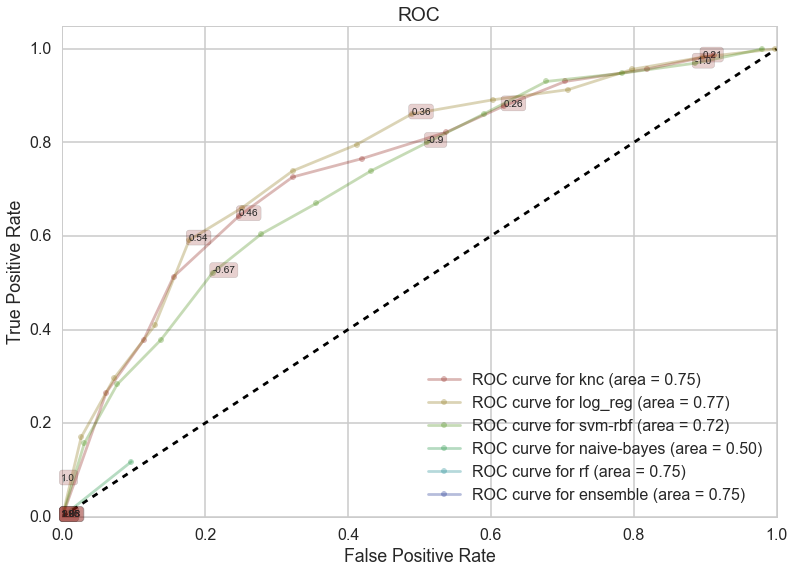

In [176]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("knc",knc, y_test, X_test, labe=200, skip=50)
    make_roc("log_reg", log_reg, y_test, X_test, labe=200, skip=50, ax=ax)
    make_roc("svm-rbf", clf, y_test, X_test, labe=200, skip=50, ax=ax, proba=False)
    make_roc("naive-bayes", nb, y_test, X_test_w, labe=200, skip=50, ax=ax)
    make_roc("rf", rf_best, y_test, X_test, labe=200, skip=50, ax=ax)
    make_roc("ensemble", est, y_test, dfensembletest[['knn', 'log', 'svm', 'rf', 'nb']].values, labe=200, skip=50, ax=ax, proba=False)

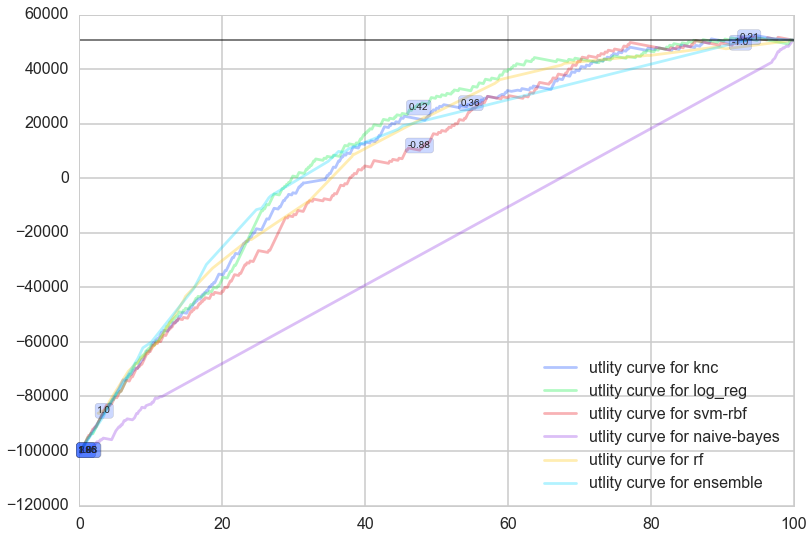

In [177]:
with sns.color_palette("bright"):
    ax=make_profit("knc",knc, y_test, X_test, u, threshold=True, labe=300)
    make_profit("log_reg",log_reg, y_test, X_test, u, threshold=True, labe=300, ax=ax)
    make_profit("svm-rbf",clf, y_test, X_test, u, threshold=True, labe=300, ax=ax, proba=False)
    make_profit("naive-bayes",nb, y_test, X_test_w, u, threshold=True, labe=300, ax=ax)
    make_profit("rf",rf_best, y_test, X_test, u, threshold=True, labe=300, ax=ax)
    make_profit("ensemble",est, y_test, dfensembletest[['knn', 'log', 'svm', 'rf', 'nb']].values, u, threshold=True, labe=300, ax=ax, proba=False)
    plt.plot([0,100],[ones_baseline_profit,ones_baseline_profit],'k-', alpha=0.5, lw=2)

In the end, our ensemble was in line with many other models under different threshold levels. The log-reg model had the best highest area under the curve, but under our profit assumptions we don't seem to beat the baseline by much - implying that there are always some companies that are successful that our models reject until we reach the threshold of accepting everything. Picking startups is not easy!